In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import datetime as dt
import pyarrow.feather as feather
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import holidays

#Setup the figures to be higher DPI when displayed in the notebook and saved
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

#Determine if you want to save the figures or just display them in the notebook
save_figure_option = False

## Import the Data
We need to import the feather files for each of the stations in the L network

In [2]:
#helpful stations csv
station_info_df = pd.read_csv("data/station_id_information.csv")
station_info_df.head()

,station_id,station_name
0,40010,Austin
1,40020,Harlem/Lake
2,40030,Pulaski
3,40040,Quincy/Wells
4,40050,Davis


In [3]:
stations = station_info_df["station_id"].values
station_entries_dfs = {} #create the dictionary
#Read in all the feather files and put them into a dictionary
for station in stations:
    path = "data/feathers/" + str(station) + "_station_entries_2017_2024"
    station_df = feather.read_feather(path)
    station_entries_dfs[int(station)] = station_df

In [4]:
station_entries_dfs[40010].head()

,station_id,date,daytype,rides,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,ADA,RED,BLUE,GREEN,BROWN,PURPLE,PURPLE EXPRESS,YELLOW,PINK,ORANGE,latitude,longitude
0,40010,2024-08-31,A,394,30002.0,W,Austin (Forest Pk-bound),Austin,False,False,True,False,False,False,False,False,False,False,41.870851,-87.776812
1,40010,2024-08-31,A,394,30001.0,E,Austin (O'Hare-bound),Austin,False,False,True,False,False,False,False,False,False,False,41.870851,-87.776812
2,40010,2024-08-30,W,680,30001.0,E,Austin (O'Hare-bound),Austin,False,False,True,False,False,False,False,False,False,False,41.870851,-87.776812
3,40010,2024-08-30,W,680,30002.0,W,Austin (Forest Pk-bound),Austin,False,False,True,False,False,False,False,False,False,False,41.870851,-87.776812
4,40010,2024-08-29,W,779,30001.0,E,Austin (O'Hare-bound),Austin,False,False,True,False,False,False,False,False,False,False,41.870851,-87.776812


## Simple Linear Regression Model
This section puts together the baseline model for the original dataset without engineering any features yet. 

In [18]:
testing_cutoff = station_entries_dfs[40010][station_entries_dfs[40010]["date"] == datetime(2024, 1, 1)].index[0]
testing_df = station_entries_dfs[40010].iloc[:testing_cutoff].copy()
training_df = station_entries_dfs[40010].iloc[testing_cutoff:].copy()

print(len(training_df), len(testing_df))

5114 486


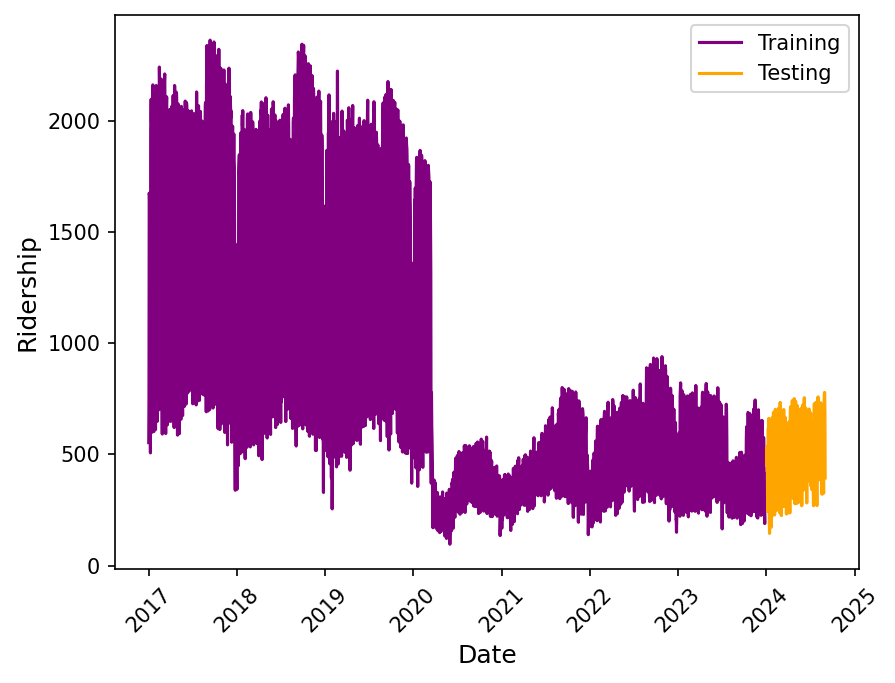

In [19]:
fig, ax = plt.subplots()

sns.lineplot(data=training_df, x="date", y="rides", label="Training", color="purple", ax=ax)
sns.lineplot(data=testing_df, x="date", y="rides", label="Testing", color="orange", ax=ax)
plt.xticks(rotation=45)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Ridership", fontsize=12)
plt.legend()
if save_figure_option:
    plt.savefig('figures/testing_training_plot.png', bbox_inches='tight')
plt.show()

In [33]:
station_entries_dfs[40010]["month"] = station_entries_dfs[40010]["date"].apply(lambda d: (d.month))
station_entries_dfs[40010]["day_of_week"] = station_entries_dfs[40010]["date"].apply(lambda d: (d.weekday()))
station_entries_dfs[40010]["year"] = station_entries_dfs[40010]["date"].apply(lambda d: (d.year))
station_entries_dfs[40010]["day"] = station_entries_dfs[40010]["date"].apply(lambda d: (d.day))

dummies_daytype = pd.get_dummies(station_entries_dfs[40010]["daytype"], prefix="daytype", dtype="float")
dummies_direction = pd.get_dummies(station_entries_dfs[40010]["DIRECTION_ID"], prefix="direction", dtype="float")
dummies_month = pd.get_dummies(station_entries_dfs[40010]["month"], prefix="month", dtype="float")
dummies_weekday = pd.get_dummies(station_entries_dfs[40010]["day_of_week"], prefix="day_of_week", dtype="float")
dummies_year = pd.get_dummies(station_entries_dfs[40010]["year"], prefix="year", dtype="float")

merged_with_dummies = dummies_daytype.merge(station_entries_dfs[40010], left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_direction, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_month, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_weekday, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_year, left_index=True, right_index=True)

dummies_direction.head()

,direction_E,direction_N,direction_S,direction_W
0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0


In [32]:
dummies_year.head()

,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [34]:
features.clear()
features = ["month_{}".format(m) for m in range(1,13)]
features.extend(["day_of_week_{}".format(d) for d in range(7)])
features.append("daytype_A")
features.append("daytype_U")
features.append("daytype_W")
features.append("direction_E")
features.append("direction_N")
features.append("direction_S")
features.append("direction_W")
features.append("RED")
features.append("BLUE")
features.append("GREEN")
features.append("BROWN")
features.append("PURPLE")
features.append("PURPLE EXPRESS")
features.append("YELLOW")
features.append("PINK")
features.append("ORANGE")
features.append("ADA")
features.append("year_2017")
features.append("year_2018")
features.append("year_2019")
features.append("year_2020")
features.append("year_2021")
features.append("year_2022")
features.append("year_2023")
features.append("year_2024")

testing_df = merged_with_dummies.iloc[:testing_cutoff].copy()
training_df = merged_with_dummies.iloc[testing_cutoff:].copy()

train_X = training_df[features].values
test_X = testing_df[features].values

train_y = training_df["rides"].values
test_y = testing_df["rides"].values

In [37]:
ridge_model = Ridge(positive=True)
ridge_model.fit(train_X, train_y)
testing_df["ridge_pred"] = ridge_model.predict(test_X)
training_df["ridge_pred"] = ridge_model.predict(train_X)

ridge_rmse = np.sqrt(mean_squared_error(test_y, testing_df["ridge_pred"].values))
ridge_mape = mean_absolute_percentage_error(test_y, testing_df["ridge_pred"].values)
print("RMSE: {:.0f}".format(ridge_rmse))
print("MAPE: {:.2%}".format(ridge_mape))

RMSE: 198
MAPE: 40.74%


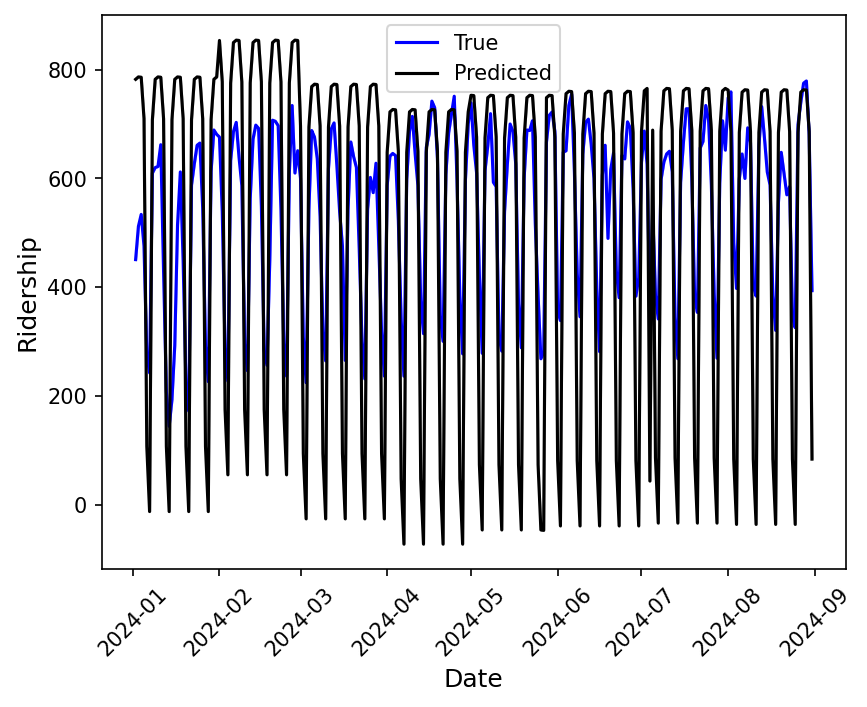

In [44]:
fig, ax = plt.subplots()

sns.lineplot(data=testing_df, x="date", y="rides", label="True", color="blue", ax=ax)
sns.lineplot(data=testing_df, x="date", y="ridge_pred", label="Predicted", color="black", ax=ax)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Ridership", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
if save_figure_option:
    plt.savefig('figures/base_ridge_testing_predicted.png', bbox_inches='tight')
plt.show()

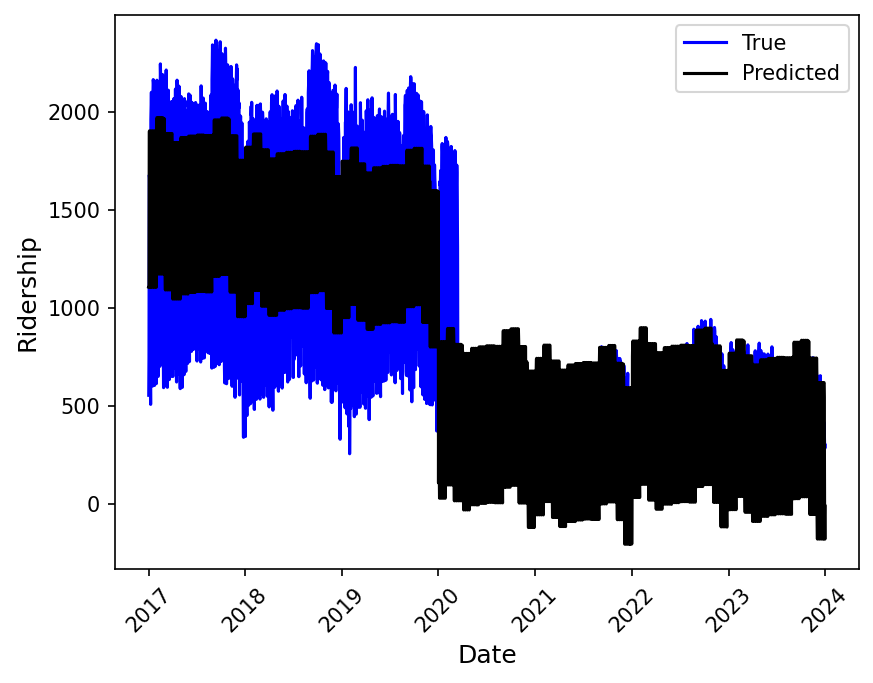

In [45]:
fig, ax = plt.subplots()

sns.lineplot(data=training_df, x="date", y="rides", label="True", color="blue", ax=ax)
sns.lineplot(data=training_df, x="date", y="ridge_pred", label="Predicted", color="black", ax=ax)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Ridership", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
if save_figure_option:
    plt.savefig('figures/ridge_training_predicted.png', bbox_inches='tight')
plt.show()

## Post Pandemic Only
The model was able to determine that there is a large drop off during the pandemic, but after the pandemic years, the model is no longer very accurate; hence, the same process as above is attempted but with just the data from the pandemic forward. This means that rather than starting in 2017, the data will start in 2020. 

In [161]:
stations = station_info_df["station_id"].values
station_entries_dfs = {} #create the dictionary
#Read in all the feather files and put them into a dictionary
for station in stations:
    path = "data/feathers/" + str(station) + "_station_entries_2020_2024"
    station_df = feather.read_feather(path)
    station_entries_dfs[int(station)] = station_df

In [48]:
testing_cutoff = station_entries_dfs[40010][station_entries_dfs[40010]["date"] == datetime(2024, 1, 1)].index[0]
testing_df = station_entries_dfs[40010].iloc[:testing_cutoff].copy()
training_df = station_entries_dfs[40010].iloc[testing_cutoff:].copy()

print(len(training_df), len(testing_df))

2714 486


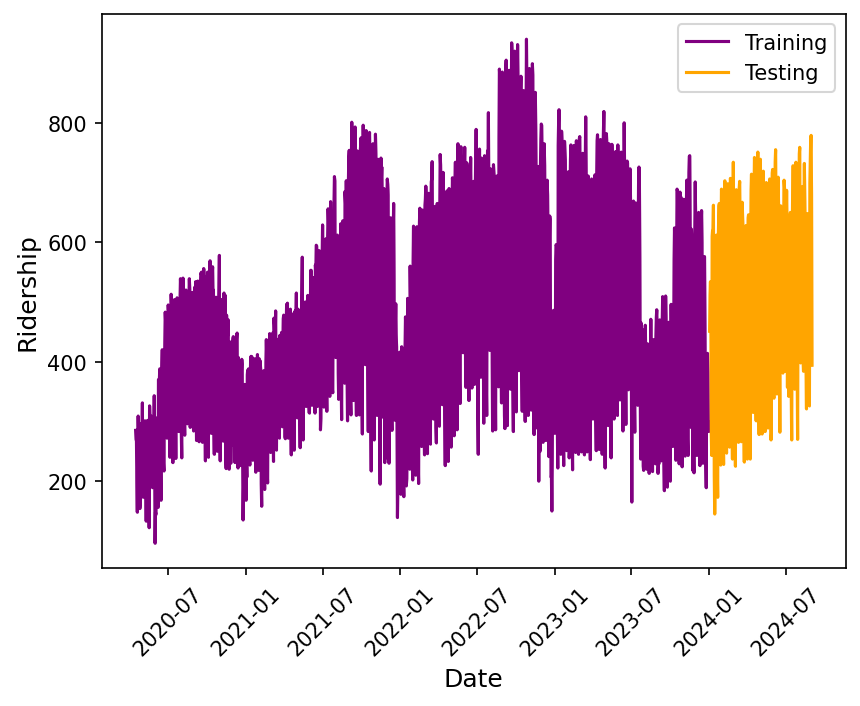

In [49]:
fig, ax = plt.subplots()

sns.lineplot(data=training_df, x="date", y="rides", label="Training", color="purple", ax=ax)
sns.lineplot(data=testing_df, x="date", y="rides", label="Testing", color="orange", ax=ax)
plt.xticks(rotation=45)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Ridership", fontsize=12)
plt.legend()
if save_figure_option:
    plt.savefig('figures/testing_training_plot.png', bbox_inches='tight')
plt.show()

In [50]:
station_entries_dfs[40010]["month"] = station_entries_dfs[40010]["date"].apply(lambda d: (d.month))
station_entries_dfs[40010]["day_of_week"] = station_entries_dfs[40010]["date"].apply(lambda d: (d.weekday()))
station_entries_dfs[40010]["year"] = station_entries_dfs[40010]["date"].apply(lambda d: (d.year))
station_entries_dfs[40010]["day"] = station_entries_dfs[40010]["date"].apply(lambda d: (d.day))

dummies_daytype = pd.get_dummies(station_entries_dfs[40010]["daytype"], prefix="daytype", dtype="float")
dummies_direction = pd.get_dummies(station_entries_dfs[40010]["DIRECTION_ID"], prefix="direction", dtype="float")
dummies_month = pd.get_dummies(station_entries_dfs[40010]["month"], prefix="month", dtype="float")
dummies_weekday = pd.get_dummies(station_entries_dfs[40010]["day_of_week"], prefix="day_of_week", dtype="float")
dummies_year = pd.get_dummies(station_entries_dfs[40010]["year"], prefix="year", dtype="float")

merged_with_dummies = dummies_daytype.merge(station_entries_dfs[40010], left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_direction, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_month, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_weekday, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_year, left_index=True, right_index=True)

dummies_direction.head()

,direction_E,direction_N,direction_S,direction_W
0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0


In [52]:
features.clear()
features = ["month_{}".format(m) for m in range(1,13)]
features.extend(["day_of_week_{}".format(d) for d in range(7)])
features.append("daytype_A")
features.append("daytype_U")
features.append("daytype_W")
features.append("direction_E")
features.append("direction_N")
features.append("direction_S")
features.append("direction_W")
features.append("RED")
features.append("BLUE")
features.append("GREEN")
features.append("BROWN")
features.append("PURPLE")
features.append("PURPLE EXPRESS")
features.append("YELLOW")
features.append("PINK")
features.append("ORANGE")
features.append("ADA")
features.append("year_2020")
features.append("year_2021")
features.append("year_2022")
features.append("year_2023")
features.append("year_2024")

testing_df = merged_with_dummies.iloc[:testing_cutoff].copy()
training_df = merged_with_dummies.iloc[testing_cutoff:].copy()

train_X = training_df[features].values
test_X = testing_df[features].values

train_y = training_df["rides"].values
test_y = testing_df["rides"].values

In [53]:
ridge_model = Ridge(positive=True)
ridge_model.fit(train_X, train_y)
testing_df["ridge_pred"] = ridge_model.predict(test_X)
training_df["ridge_pred"] = ridge_model.predict(train_X)

ridge_rmse = np.sqrt(mean_squared_error(test_y, testing_df["ridge_pred"].values))
ridge_mape = mean_absolute_percentage_error(test_y, testing_df["ridge_pred"].values)
print("RMSE: {:.0f}".format(ridge_rmse))
print("MAPE: {:.2%}".format(ridge_mape))

RMSE: 158
MAPE: 28.97%


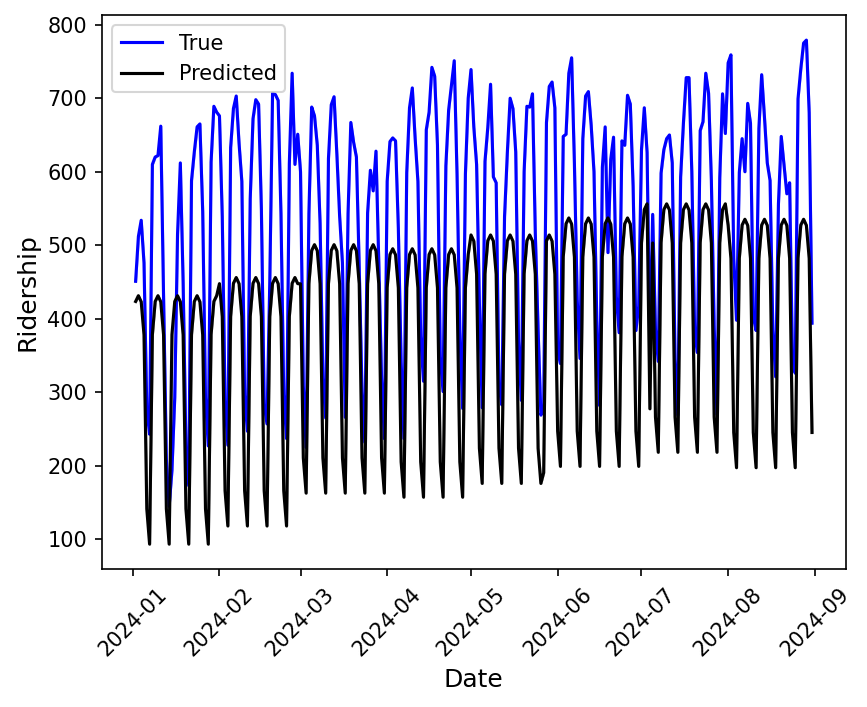

In [55]:
fig, ax = plt.subplots()

sns.lineplot(data=testing_df, x="date", y="rides", label="True", color="blue", ax=ax)
sns.lineplot(data=testing_df, x="date", y="ridge_pred", label="Predicted", color="black", ax=ax)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Ridership", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
if save_figure_option:
    plt.savefig('figures/base_ridge_testing_predicted_post_pandemic.png', bbox_inches='tight')
plt.show()

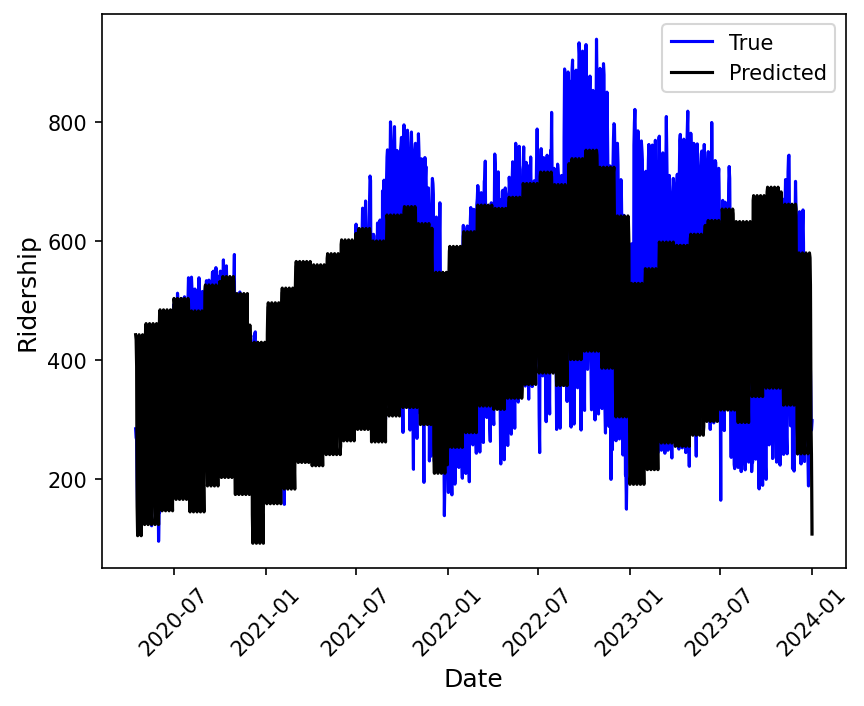

In [56]:
fig, ax = plt.subplots()

sns.lineplot(data=training_df, x="date", y="rides", label="True", color="blue", ax=ax)
sns.lineplot(data=training_df, x="date", y="ridge_pred", label="Predicted", color="black", ax=ax)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Ridership", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
if save_figure_option:
    plt.savefig('figures/ridge_training_predicted_post_pandemic.png', bbox_inches='tight')
plt.show()

From the above, there is a definite improvement in the model just using the post pandemic data. The MAPE went from over 40% to just under 30% by making that change. Additionally, the predictions demonstrate more of the seasonality that is present in the actual dataset versus the model that included data from the pre pandemic period. The COVID-19 pandemic really changed the world of transit, and what would make the most sense for the stakeholders of the CTA is for the forecasting to focus on the upward trend since the pandemic. 

## All the Stations
Now that we have proven out the techniques for modeling using the Ridge regression on a single station, we will apply these to all the stations with one very large loop

In [68]:
#Test out how to get the station name
station_info_df["station_name"].loc[station_info_df["station_id"] == 40020].iloc[0]

'Harlem/Lake'

In [70]:
#Don't want those pesky / runing our paths
station_info_df["station_name"] = station_info_df["station_name"].str.replace("/", "_")
station_info_df["station_name"].loc[station_info_df["station_id"] == 40020].iloc[0]

'Harlem_Lake'

In [78]:
mapes = []
rmses = []
stations = []

features.clear()
features = ["month_{}".format(m) for m in range(1,13)]
features.extend(["day_of_week_{}".format(d) for d in range(7)])
features.append("daytype_A")
features.append("daytype_U")
features.append("daytype_W")
features.append("direction_E")
features.append("direction_N")
features.append("direction_S")
features.append("direction_W")
features.append("RED")
features.append("BLUE")
features.append("GREEN")
features.append("BROWN")
features.append("PURPLE")
features.append("PURPLE EXPRESS")
features.append("YELLOW")
features.append("PINK")
features.append("ORANGE")
features.append("ADA")
features.append("year_2020")
features.append("year_2021")
features.append("year_2022")
features.append("year_2023")
features.append("year_2024")

#The big loop
for station_id, station_entries_df in station_entries_dfs.items():
    if station_id == 40340:
        continue
    if station_id == 40770:
        continue
    if station_id == 41710: 
        continue
    print("Working on station ID: " + str(station_id))
    station_name = station_info_df["station_name"].loc[station_info_df["station_id"] == station_id].iloc[0]
    stations.append(station_name)
    figure_path = "figures/" + station_name + "_ridge_model_predictions.png"

    testing_cutoff = station_entries_df[station_entries_df["date"] == datetime(2024, 1, 1)].index[0]
    
    station_entries_df["month"] = station_entries_df["date"].apply(lambda d: (d.month))
    station_entries_df["day_of_week"] = station_entries_df["date"].apply(lambda d: (d.weekday()))
    station_entries_df["year"] = station_entries_df["date"].apply(lambda d: (d.year))
    station_entries_df["day"] = station_entries_df["date"].apply(lambda d: (d.day))
    
    dummies_daytype = pd.get_dummies(station_entries_df["daytype"], prefix="daytype", dtype="float")
    dummies_direction = pd.get_dummies(station_entries_df["DIRECTION_ID"], prefix="direction", dtype="float")
    dummies_month = pd.get_dummies(station_entries_df["month"], prefix="month", dtype="float")
    dummies_weekday = pd.get_dummies(station_entries_df["day_of_week"], prefix="day_of_week", dtype="float")
    dummies_year = pd.get_dummies(station_entries_df["year"], prefix="year", dtype="float")
    
    merged_with_dummies = dummies_daytype.merge(station_entries_df, left_index=True, right_index=True)
    merged_with_dummies = merged_with_dummies.merge(dummies_direction, left_index=True, right_index=True)
    merged_with_dummies = merged_with_dummies.merge(dummies_month, left_index=True, right_index=True)
    merged_with_dummies = merged_with_dummies.merge(dummies_weekday, left_index=True, right_index=True)
    merged_with_dummies = merged_with_dummies.merge(dummies_year, left_index=True, right_index=True)

    testing_df = merged_with_dummies.iloc[:testing_cutoff].copy()
    training_df = merged_with_dummies.iloc[testing_cutoff:].copy()
    
    train_X = training_df[features].values
    test_X = testing_df[features].values
    
    train_y = training_df["rides"].values
    test_y = testing_df["rides"].values

    ridge_model = Ridge(positive=True)
    ridge_model.fit(train_X, train_y)
    testing_df["ridge_pred"] = ridge_model.predict(test_X)
    training_df["ridge_pred"] = ridge_model.predict(train_X)
    
    ridge_rmse = np.sqrt(mean_squared_error(test_y, testing_df["ridge_pred"].values))
    ridge_mape = mean_absolute_percentage_error(test_y, testing_df["ridge_pred"].values)
    mapes.append(ridge_mape)
    rmses.append(ridge_rmse)

    fig, ax = plt.subplots()

    sns.lineplot(data=testing_df, x="date", y="rides", label="True", color="purple", ax=ax)
    sns.lineplot(data=testing_df, x="date", y="ridge_pred", label="Predicted", color="black", ax=ax)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Ridership", fontsize=12)
    plt.xticks(rotation=45)
    plt.title("Ridge Regression Result for " + station_name)
    plt.legend()
    plt.savefig(figure_path, bbox_inches='tight')
    plt.close()

print("Done!")

Working on station ID: 40010
Working on station ID: 40020
Working on station ID: 40030
Working on station ID: 40040
Working on station ID: 40050
Working on station ID: 40060
Working on station ID: 40070
Working on station ID: 40080
Working on station ID: 40090
Working on station ID: 40100
Working on station ID: 40120
Working on station ID: 40130
Working on station ID: 40140
Working on station ID: 40150
Working on station ID: 40160
Working on station ID: 40170
Working on station ID: 40180
Working on station ID: 40190
Working on station ID: 40210
Working on station ID: 40220
Working on station ID: 40230
Working on station ID: 40240
Working on station ID: 40250
Working on station ID: 40260
Working on station ID: 40270
Working on station ID: 40280
Working on station ID: 40290
Working on station ID: 40300
Working on station ID: 40310
Working on station ID: 40320
Working on station ID: 40330
Working on station ID: 40350
Working on station ID: 40360
Working on station ID: 40370
Working on sta

In [87]:
results_df = pd.DataFrame({"Station_Name": stations, "MAPE": mapes, "RMSE": rmses})
results_df = results_df.sort_values(by="MAPE", ascending=False)
results_df.head(30)

,Station_Name,MAPE,RMSE
3,Quincy_Wells,1.054752,3281.742208
31,UIC-Halsted,0.982606,2255.340262
12,Dempster-Skokie,0.893391,512.550014
127,Addison,0.843164,5268.114382
65,Washington_Wells,0.835383,2403.094528
135,Morgan,0.814636,2362.219282
23,State_Lake,0.773587,5284.602546
89,Cermak-Chinatown,0.772562,2353.949105
139,Cermak-McCormick Place,0.752264,859.342511
136,Lake,0.739792,6682.879898


Stations 40340, 40770, and 41710 do not have data into 2024 since they closed prior for repairs or as part of the rpm project. Thus, these are ignored and removed from the modeling.

## Random Forest Modeling
Now that there is a base model, a random forest model will be trained and tested to see if performance improves. 

In [5]:
testing_cutoff = station_entries_dfs[40350][station_entries_dfs[40350]["date"] == datetime(2024, 1, 1)].index[0]
testing_df = station_entries_dfs[40350].iloc[:testing_cutoff].copy()
training_df = station_entries_dfs[40350].iloc[testing_cutoff:].copy()

print(len(training_df), len(testing_df))

5060 486


In [6]:
station_entries_dfs[40350]["month"] = station_entries_dfs[40350]["date"].apply(lambda d: (d.month))
station_entries_dfs[40350]["day_of_week"] = station_entries_dfs[40350]["date"].apply(lambda d: (d.weekday()))
station_entries_dfs[40350]["year"] = station_entries_dfs[40350]["date"].apply(lambda d: (d.year))
station_entries_dfs[40350]["day"] = station_entries_dfs[40350]["date"].apply(lambda d: (d.day))
#Grab elapsed days from timedelta
first_date = station_entries_dfs[40350]["date"][len(station_entries_dfs[40350])-1]
station_entries_dfs[40350]["elapsed_days"] = station_entries_dfs[40350]["date"].apply(lambda d: (d - first_date).days)

dummies_daytype = pd.get_dummies(station_entries_dfs[40350]["daytype"], prefix="daytype", dtype="float")
dummies_direction = pd.get_dummies(station_entries_dfs[40350]["DIRECTION_ID"], prefix="direction", dtype="float")
dummies_month = pd.get_dummies(station_entries_dfs[40350]["month"], prefix="month", dtype="float")
dummies_weekday = pd.get_dummies(station_entries_dfs[40350]["day_of_week"], prefix="day_of_week", dtype="float")
dummies_year = pd.get_dummies(station_entries_dfs[40350]["year"], prefix="year", dtype="float")

merged_with_dummies = dummies_daytype.merge(station_entries_dfs[40350], left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_direction, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_month, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_weekday, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_year, left_index=True, right_index=True)

In [9]:
features.clear()
features = ["month_{}".format(m) for m in range(1,13)]
features.extend(["day_of_week_{}".format(d) for d in range(7)])
features.append("daytype_A")
features.append("daytype_U")
features.append("daytype_W")
features.append("direction_E")
features.append("direction_N")
features.append("direction_S")
features.append("direction_W")
features.append("RED")
features.append("BLUE")
features.append("GREEN")
features.append("BROWN")
features.append("PURPLE")
features.append("PURPLE EXPRESS")
features.append("YELLOW")
features.append("PINK")
features.append("ORANGE")
features.append("ADA")
features.append("elapsed_days")
# features.append("year_2020")
# features.append("year_2021")
# features.append("year_2022")
# features.append("year_2023")
# features.append("year_2024")

testing_df = merged_with_dummies.iloc[:testing_cutoff].copy()
training_df = merged_with_dummies.iloc[testing_cutoff:].copy()

train_X = training_df[features].values
test_X = testing_df[features].values

train_y = training_df["rides"].values
test_y = testing_df["rides"].values
training_df.head()

,daytype_A,daytype_U,daytype_W,station_id,date,daytype,rides,STOP_ID,DIRECTION_ID,STOP_NAME,...,day_of_week_5,day_of_week_6,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
486,0.0,1.0,0.0,40350,2024-01-01,U,690,30069.0,W,UIC-Halsted (Forest Pk-bound),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
487,0.0,1.0,0.0,40350,2024-01-01,U,690,30068.0,E,UIC-Halsted (O'Hare-bound),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
488,0.0,1.0,0.0,40350,2023-12-31,U,627,30068.0,E,UIC-Halsted (O'Hare-bound),...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
489,0.0,1.0,0.0,40350,2023-12-31,U,627,30069.0,W,UIC-Halsted (Forest Pk-bound),...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
490,1.0,0.0,0.0,40350,2023-12-30,A,744,30069.0,W,UIC-Halsted (Forest Pk-bound),...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
rand_forest_model = RandomForestRegressor(n_estimators=1000, max_depth=10, n_jobs=7)
rand_forest_model.fit(train_X, train_y)
testing_df["rand_forest_pred"] = rand_forest_model.predict(test_X)
training_df["rand_forest_pred"] = rand_forest_model.predict(train_X)

rand_forest_rmse = np.sqrt(mean_squared_error(test_y, testing_df["rand_forest_pred"].values))
rand_forest_mape = mean_absolute_percentage_error(test_y, testing_df["rand_forest_pred"].values)
print("RMSE: {:.0f}".format(rand_forest_rmse))
print("MAPE: {:.2%}".format(rand_forest_mape))

feature_importances = rand_forest_model.feature_importances_
importance_df = pd.DataFrame({"Feature": training_df[features].columns, "Importance_Score": feature_importances})
importance_df = importance_df.sort_values(by="Importance_Score", ascending=False)
importance_df.head(10)

RMSE: 966
MAPE: 29.95%


,Feature,Importance_Score
36,elapsed_days,0.455195
21,daytype_W,0.338009
8,month_9,0.048331
9,month_10,0.047912
10,month_11,0.029713
1,month_2,0.025557
3,month_4,0.021103
2,month_3,0.016310
0,month_1,0.004677
7,month_8,0.003620


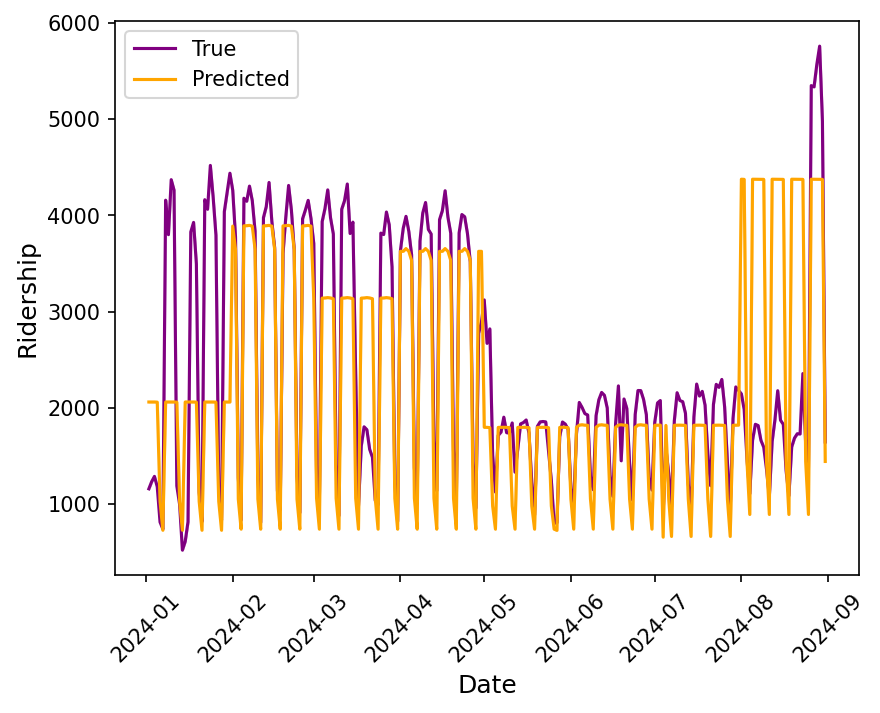

In [11]:
fig, ax = plt.subplots()

# sns.lineplot(data=training_df, x="date", y="rides", label="True", color="blue", ax=ax)
# sns.lineplot(data=training_df, x="date", y="rand_forest_pred", label="Predicted", color="black", ax=ax)
sns.lineplot(data=testing_df, x="date", y="rides", label="True", color="purple", ax=ax)
sns.lineplot(data=testing_df, x="date", y="rand_forest_pred", label="Predicted", color="orange", ax=ax)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Ridership", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
if save_figure_option:
    plt.savefig('figures/base_rand_forest_testing_predicted_post_pandemic.png', bbox_inches='tight')
plt.show()

### Feature Engineering
Now that the random forest model is confirmed to perform better than the standard linear regression, some additional feature engineering is performed to further improve performance. 

In [12]:
#elapsed days
#Grab elapsed days from timedelta
first_date = station_entries_dfs[40350]["date"][len(station_entries_dfs[40350])-1]
station_entries_dfs[40350]["elapsed_days"] = station_entries_dfs[40350]["date"].apply(lambda d: (d - first_date).days)
station_entries_dfs[40350].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5546 entries, 0 to 5545
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   station_id      5546 non-null   int64         
 1   date            5546 non-null   datetime64[ns]
 2   daytype         5546 non-null   category      
 3   rides           5546 non-null   int64         
 4   STOP_ID         5546 non-null   category      
 5   DIRECTION_ID    5546 non-null   category      
 6   STOP_NAME       5546 non-null   category      
 7   STATION_NAME    5546 non-null   category      
 8   ADA             5546 non-null   bool          
 9   RED             5546 non-null   bool          
 10  BLUE            5546 non-null   bool          
 11  GREEN           5546 non-null   bool          
 12  BROWN           5546 non-null   bool          
 13  PURPLE          5546 non-null   bool          
 14  PURPLE EXPRESS  5546 non-null   bool          
 15  YELLOW   

In [13]:
us_holidays = holidays.US(years=range(2020, 2025))
holiday_df = pd.DataFrame({'date': list(us_holidays.keys()), 'holiday_name': list(us_holidays.values())})
# Convert the 'date' column to datetime
holiday_df['date'] = pd.to_datetime(holiday_df['date'])

# Sort df by 'date' 
sorted_holiday_df = holiday_df.sort_values(by='date')
filtered_holiday_df = sorted_holiday_df[(sorted_holiday_df['date'] >= '2020-04-15') & (sorted_holiday_df['date'] <= '2024-08-31')]
filtered_holiday_df.head()

,date,holiday_name
1,2020-05-25,Memorial Day
3,2020-07-03,Independence Day (observed)
2,2020-07-04,Independence Day
4,2020-09-07,Labor Day
10,2020-10-12,Columbus Day


In [14]:
station_entries_dfs[40350]['is_holiday'] = station_entries_dfs[40350]['date'].isin(filtered_holiday_df['date']).astype(bool)
station_entries_dfs[40350].head()

,station_id,date,daytype,rides,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,ADA,RED,...,PINK,ORANGE,latitude,longitude,month,day_of_week,year,day,elapsed_days,is_holiday
0,40350,2024-08-31,A,1646,30069.0,W,UIC-Halsted (Forest Pk-bound),UIC-Halsted,True,False,...,False,False,41.875474,-87.649707,8,5,2024,31,2799,False
1,40350,2024-08-31,A,1646,30068.0,E,UIC-Halsted (O'Hare-bound),UIC-Halsted,True,False,...,False,False,41.875474,-87.649707,8,5,2024,31,2799,False
2,40350,2024-08-30,W,4977,30068.0,E,UIC-Halsted (O'Hare-bound),UIC-Halsted,True,False,...,False,False,41.875474,-87.649707,8,4,2024,30,2798,False
3,40350,2024-08-30,W,4977,30069.0,W,UIC-Halsted (Forest Pk-bound),UIC-Halsted,True,False,...,False,False,41.875474,-87.649707,8,4,2024,30,2798,False
4,40350,2024-08-29,W,5758,30068.0,E,UIC-Halsted (O'Hare-bound),UIC-Halsted,True,False,...,False,False,41.875474,-87.649707,8,3,2024,29,2797,False


In [15]:
station_entries_dfs[40350]["holiday_prev_1"] = station_entries_dfs[40350]["is_holiday"].shift(periods=-1, fill_value=False)
station_entries_dfs[40350]["holiday_next_1"] = station_entries_dfs[40350]["is_holiday"].shift(periods=1, fill_value=False)
station_entries_dfs[40350]["holiday_prev_2"] = station_entries_dfs[40350]["is_holiday"].shift(periods=-2, fill_value=False)
station_entries_dfs[40350]["holiday_next_2"] = station_entries_dfs[40350]["is_holiday"].shift(periods=2, fill_value=False)
station_entries_dfs[40350]["holiday_prev_3"] = station_entries_dfs[40350]["is_holiday"].shift(periods=-3, fill_value=False)
station_entries_dfs[40350]["holiday_next_3"] = station_entries_dfs[40350]["is_holiday"].shift(periods=3, fill_value=False)
station_entries_dfs[40350].head()

,station_id,date,daytype,rides,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,ADA,RED,...,year,day,elapsed_days,is_holiday,holiday_prev_1,holiday_next_1,holiday_prev_2,holiday_next_2,holiday_prev_3,holiday_next_3
0,40350,2024-08-31,A,1646,30069.0,W,UIC-Halsted (Forest Pk-bound),UIC-Halsted,True,False,...,2024,31,2799,False,False,False,False,False,False,False
1,40350,2024-08-31,A,1646,30068.0,E,UIC-Halsted (O'Hare-bound),UIC-Halsted,True,False,...,2024,31,2799,False,False,False,False,False,False,False
2,40350,2024-08-30,W,4977,30068.0,E,UIC-Halsted (O'Hare-bound),UIC-Halsted,True,False,...,2024,30,2798,False,False,False,False,False,False,False
3,40350,2024-08-30,W,4977,30069.0,W,UIC-Halsted (Forest Pk-bound),UIC-Halsted,True,False,...,2024,30,2798,False,False,False,False,False,False,False
4,40350,2024-08-29,W,5758,30068.0,E,UIC-Halsted (O'Hare-bound),UIC-Halsted,True,False,...,2024,29,2797,False,False,False,False,False,False,False


In [16]:
station_entries_dfs[40350]["month"] = station_entries_dfs[40350]["date"].apply(lambda d: (d.month))
station_entries_dfs[40350]["day_of_week"] = station_entries_dfs[40350]["date"].apply(lambda d: (d.weekday()))
station_entries_dfs[40350]["year"] = station_entries_dfs[40350]["date"].apply(lambda d: (d.year))
station_entries_dfs[40350]["day"] = station_entries_dfs[40350]["date"].apply(lambda d: (d.day))

dummies_daytype = pd.get_dummies(station_entries_dfs[40350]["daytype"], prefix="daytype", dtype="float")
dummies_direction = pd.get_dummies(station_entries_dfs[40350]["DIRECTION_ID"], prefix="direction", dtype="float")
dummies_month = pd.get_dummies(station_entries_dfs[40350]["month"], prefix="month", dtype="float")
dummies_weekday = pd.get_dummies(station_entries_dfs[40350]["day_of_week"], prefix="day_of_week", dtype="float")
dummies_year = pd.get_dummies(station_entries_dfs[40350]["year"], prefix="year", dtype="float")
dummies_holiday = pd.get_dummies(station_entries_dfs[40350]["is_holiday"], prefix="holiday", dtype="float")
dummies_holiday_prev_1 = pd.get_dummies(station_entries_dfs[40350]["holiday_prev_1"], prefix="hol_prev_1", dtype="float")
dummies_holiday_prev_2 = pd.get_dummies(station_entries_dfs[40350]["holiday_prev_2"], prefix="hol_prev_2", dtype="float")
dummies_holiday_prev_3 = pd.get_dummies(station_entries_dfs[40350]["holiday_prev_3"], prefix="hol_prev_3", dtype="float")
dummies_holiday_next_1 = pd.get_dummies(station_entries_dfs[40350]["holiday_next_1"], prefix="hol_next_1", dtype="float")
dummies_holiday_next_2 = pd.get_dummies(station_entries_dfs[40350]["holiday_next_2"], prefix="hol_next_2", dtype="float")
dummies_holiday_next_3 = pd.get_dummies(station_entries_dfs[40350]["holiday_next_3"], prefix="hol_next_3", dtype="float")

merged_with_dummies = dummies_daytype.merge(station_entries_dfs[40350], left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_direction, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_month, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_weekday, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_year, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_holiday, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_holiday_prev_1, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_holiday_prev_2, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_holiday_prev_3, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_holiday_next_1, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_holiday_next_2, left_index=True, right_index=True)
merged_with_dummies = merged_with_dummies.merge(dummies_holiday_next_3, left_index=True, right_index=True)

dummies_holiday_next_1.head()

,hol_next_1_False,hol_next_1_True
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [17]:
features.clear()
features = ["month_{}".format(m) for m in range(1,13)]
features.extend(["day_of_week_{}".format(d) for d in range(7)])
features.append("daytype_A")
features.append("daytype_U")
features.append("daytype_W")
features.append("direction_E")
features.append("direction_N")
features.append("direction_S")
features.append("direction_W")
features.append("RED")
features.append("BLUE")
features.append("GREEN")
features.append("BROWN")
features.append("PURPLE")
features.append("PURPLE EXPRESS")
features.append("YELLOW")
features.append("PINK")
features.append("ORANGE")
features.append("ADA")
# features.append("year_2020")
# features.append("year_2021")
# features.append("year_2022")
# features.append("year_2023")
# features.append("year_2024")
features.append("elapsed_days")
features.append("holiday_False")
features.append("holiday_True")
features.append("hol_prev_1_False")
features.append("hol_prev_1_True")
features.append("hol_prev_2_False")
features.append("hol_prev_2_True")
features.append("hol_prev_3_False")
features.append("hol_prev_3_True")
features.append("hol_next_1_False")
features.append("hol_next_1_True")
features.append("hol_next_2_False")
features.append("hol_next_2_True")
features.append("hol_next_3_False")
features.append("hol_next_3_True")

testing_df = merged_with_dummies.iloc[:testing_cutoff].copy()
training_df = merged_with_dummies.iloc[testing_cutoff:].copy()

train_X = training_df[features].values
test_X = testing_df[features].values

train_y = training_df["rides"].values
test_y = testing_df["rides"].values

In [18]:
rand_forest_model = RandomForestRegressor(n_estimators=1000, max_depth=10, n_jobs=7)
rand_forest_model.fit(train_X, train_y)
testing_df["rand_forest_pred"] = rand_forest_model.predict(test_X)
training_df["rand_forest_pred"] = rand_forest_model.predict(train_X)

rand_forest_rmse = np.sqrt(mean_squared_error(test_y, testing_df["rand_forest_pred"].values))
rand_forest_mape = mean_absolute_percentage_error(test_y, testing_df["rand_forest_pred"].values)
print("RMSE: {:.0f}".format(rand_forest_rmse))
print("MAPE: {:.2%}".format(rand_forest_mape))

RMSE: 965
MAPE: 30.08%


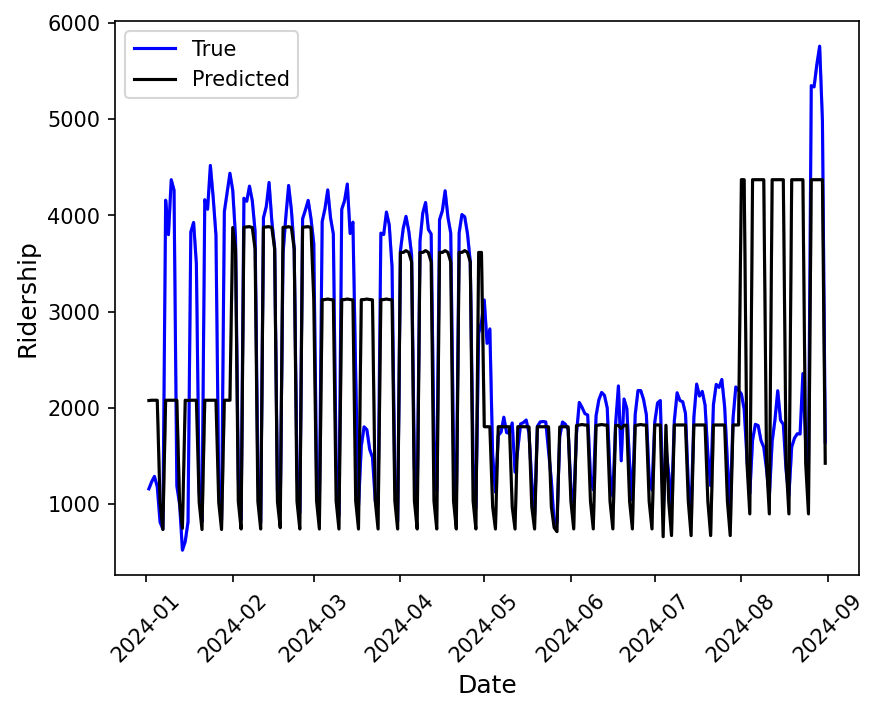

In [19]:
fig, ax = plt.subplots()

sns.lineplot(data=testing_df, x="date", y="rides", label="True", color="blue", ax=ax)
sns.lineplot(data=testing_df, x="date", y="rand_forest_pred", label="Predicted", color="black", ax=ax)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Ridership", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
if save_figure_option:
    plt.savefig('figures/holiday_rand_forest_predicted_post_pandemic.png', bbox_inches='tight')
plt.show()

### Weather Feature Engineering
The weather is likely to alter how and when people decide to take the train, so adding this information in could potentially help improve the model. 

In [22]:
weather_df = feather.read_feather("data/feathers/Weather_data")
weather_df = weather_df.drop("index", axis=1)
weather_df.head()

,AWND,PRCP,PGTM,TMAX,TMIN,Date,TAVG_new
0,33.0,0.0,0.0,28.0,-93.0,2017-01-01,-32.5
1,63.0,0.0,0.0,6.0,-105.0,2017-01-02,-49.5
2,76.0,0.0,0.0,-77.0,-149.0,2017-01-03,-113.0
3,31.0,13.0,0.0,-105.0,-199.0,2017-01-04,-152.0
4,51.0,0.0,0.0,-127.0,-243.0,2017-01-05,-185.0


In [23]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   AWND      2800 non-null   float64       
 1   PRCP      2800 non-null   float64       
 2   PGTM      2800 non-null   float64       
 3   TMAX      2800 non-null   float64       
 4   TMIN      2800 non-null   float64       
 5   Date      2800 non-null   datetime64[ns]
 6   TAVG_new  2800 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 153.3 KB


In [28]:
weather_df = weather_df[weather_df["Date"].dt.date >= dt.date(2020,4,15)].copy()
weather_df = weather_df.rename(columns={"TAVG_new":"TAVG", "Date":"date"})
weather_df.head()

,AWND,PRCP,PGTM,TMAX,TMIN,date,TAVG
1200,9.0,0.0,0.0,-55.0,-71.0,2020-04-15,-63.0
1201,53.0,18.0,0.0,17.0,-82.0,2020-04-16,-32.5
1202,34.0,0.0,0.0,100.0,-77.0,2020-04-17,11.5
1203,38.0,0.0,0.0,222.0,-5.0,2020-04-18,108.5
1204,29.0,18.0,0.0,167.0,11.0,2020-04-19,89.0


In [29]:
temp_df = pd.merge(station_entries_dfs[40350], weather_df, on="date", how="left")
temp_df.head()

,station_id,date,daytype,rides,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,ADA,RED,...,holiday_prev_2,holiday_next_2,holiday_prev_3,holiday_next_3,AWND,PRCP,PGTM,TMAX,TMIN,TAVG
0,40350,2024-08-31,A,1646,30069.0,W,UIC-Halsted (Forest Pk-bound),UIC-Halsted,True,False,...,False,False,False,False,18.0,0.0,1720.0,317.0,89.0,203.0
1,40350,2024-08-31,A,1646,30068.0,E,UIC-Halsted (O'Hare-bound),UIC-Halsted,True,False,...,False,False,False,False,18.0,0.0,1720.0,317.0,89.0,203.0
2,40350,2024-08-30,W,4977,30068.0,E,UIC-Halsted (O'Hare-bound),UIC-Halsted,True,False,...,False,False,False,False,12.0,0.0,0.0,300.0,94.0,197.0
3,40350,2024-08-30,W,4977,30069.0,W,UIC-Halsted (Forest Pk-bound),UIC-Halsted,True,False,...,False,False,False,False,12.0,0.0,0.0,300.0,94.0,197.0
4,40350,2024-08-29,W,5758,30068.0,E,UIC-Halsted (O'Hare-bound),UIC-Halsted,True,False,...,False,False,False,False,25.0,23.0,0.0,261.0,117.0,189.0
